In [37]:
import pandas as pd
import numpy as np

In [38]:
df=pd.read_csv('advertising.csv')

In [39]:
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [40]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [41]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

cat_cols = df.select_dtypes(include=['object']).columns.tolist()

In [42]:
print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)

Numerical Columns: ['TV', 'Radio', 'Newspaper', 'Sales']
Categorical Columns: []


In [43]:
for col in cat_cols:
    print(f"{col} --> {df[col].unique()}")

In [44]:
from sklearn.preprocessing import StandardScaler
X = df.drop('Sales', axis=1)
X = X.fillna(X.mean())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 
X_original = X_scaled
y = df['Sales']

In [45]:
mu = X_scaled.mean(axis=0)  
A = X_scaled - mu   

In [ ]:
def power_iteration_sym(M, max_iter=1000, tol=1e-9):
    d = M.shape[0]
    
    v = np.random.randn(d)
    v /= np.linalg.norm(v) + 1e-15

    last_val = 0.0
    for _ in range(max_iter):
        w = M @ v
        norm_w = np.linalg.norm(w)
        if norm_w < 1e-15:
            return 0.0, v
        v = w / norm_w
        
        val = float(v.T @ (M @ v))
        if abs(val - last_val) < tol * max(1.0, abs(last_val)):
            break
        last_val = val
    return val, v

In [ ]:
def top_k_eig_power_deflation(M, k, max_iter=1000, tol=1e-9):
    d = M.shape[0]
    V = np.zeros((d, k))
    vals = np.zeros(k)

    
    M_work = M.copy()

    for j in range(k):
        val, vec = power_iteration_sym(M_work, max_iter=max_iter, tol=tol)

        
        if j > 0:
            
            proj = V[:, :j] @ (V[:, :j].T @ vec)
            vec = vec - proj
            nrm = np.linalg.norm(vec)
            if nrm > 1e-15:
                vec = vec / nrm
            else:
                vals = vals[:j]
                V = V[:, :j]
                break

           
            val = float(vec.T @ (M @ vec))

        vals[j] = val
        V[:, j] = vec

       
        M_work = M_work - val * np.outer(vec, vec)

    
    order = np.argsort(-vals)
    return vals[order], V[:, order]

In [48]:
candidate_ns = [1, 2, 3,4, 5,6, 7,8,9, 10,11,12, 15]
candidate_ns = [n for n in candidate_ns if n <= A.shape[1]]

In [49]:
candidate_ns

[1, 2, 3]

In [ ]:
errors = []
 
C= (A.T @ A) / A.shape[0]  # Covariance matrix
for n in candidate_ns:
    evals_n, evecs_n = top_k_eig_power_deflation(C, k=n, max_iter=2000, tol=1e-10)
    
   
    Z = A @ evecs_n               
    X_rec = Z @ evecs_n.T + mu    
    
    
    err = float(np.sum((X_original  - X_rec) ** 2))
    errors.append(err)
    print(f"n={n:>2} | Reconstruction Error = {err:.6f}")


n= 1 | Reconstruction Error = 325.829498
n= 2 | Reconstruction Error = 129.178270
n= 3 | Reconstruction Error = 0.000000


In [51]:
evals_std, evecs_std = np.linalg.eigh(C)
idx = np.argsort(evals_std)[::-1]
evals_std = evals_std[idx]
evecs_std = evecs_std[:, idx]

In [52]:
errors_std = []
for n in candidate_ns:
    Z_std = A @ evecs_std[:, :n]
    X_rec_std = Z_std @ evecs_std[:, :n].T + mu
    err_std = float(np.sum((X_original - X_rec_std) ** 2))
    errors_std.append(err_std)


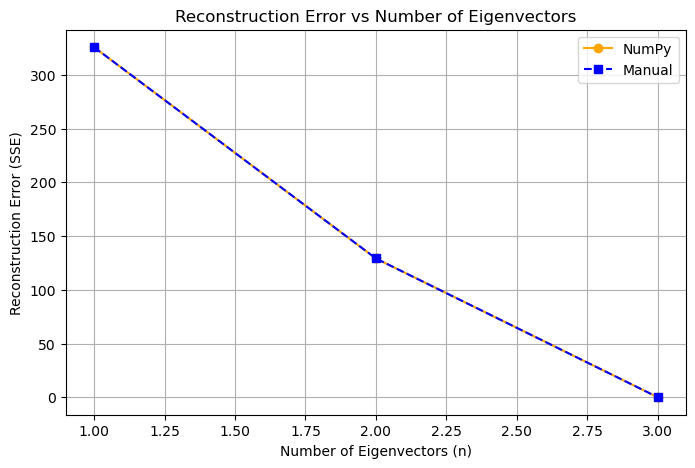

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(candidate_ns, errors_std, 'o-', color='orange', label='NumPy')
plt.plot(candidate_ns, errors, 's--', color='blue', label='Manual')  
plt.xlabel('Number of Eigenvectors (n)')
plt.ylabel('Reconstruction Error (SSE)')
plt.title('Reconstruction Error vs Number of Eigenvectors')
plt.legend()
plt.grid(True)
plt.show()
